In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
import copy

from load_user_data import load_user_data
from load_driver_data import load_driver_data
import caculate

In [2]:
class officer(object):
    def __init__(self):
        self.users = load_user_data()
        self.users_backup = copy.deepcopy(self.users)
        self.drivers = load_driver_data()
        self.drivers_backup = copy.deepcopy(self.drivers)
        self.the_maps = []
    def update_map(self):
        self.the_maps = caculate.kmeans(self.users)

In [3]:
pdw = officer()
debug = True
max_distance = 0.12  # 2km

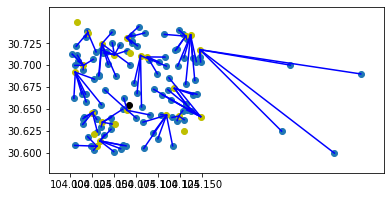

In [4]:
def kmeans_distribute(pdw):
    table = []
    while(pdw.users != []):
        pdw.update_map()
        # print(pdw.the_maps)
        user_box = []
        # 取出一个中心点和最近的司机
        center = pdw.the_maps.pop(0)
        closest_driver = caculate.find_closest_obj(center, pdw.drivers)
        pdw.drivers.remove(closest_driver)
        # 如果该中心的cluster的用户数量大于司机的座位数量
        if (len(center["users"])>=closest_driver["sites"]): 
            # 把距离司机最近的用户分配给司机
            for i in range(closest_driver["sites"]):
                closest_user = caculate.find_closest_obj(closest_driver, center["users"])
                center["users"].remove(closest_user)
                table.append([closest_user,closest_driver])
                pdw.users.remove(closest_user)
        else:
            # 还需要N个乘客才能填满座位
            need_another = closest_driver["sites"]-len(center["users"])
            # 把所有用户分配给司机
            for i in range(len(center["users"])):
                closest_user = caculate.find_closest_obj(closest_driver, center["users"])
                center["users"].remove(closest_user)
                table.append([closest_user,closest_driver])
                pdw.users.remove(closest_user)
            # 再找N个乘客来填满座位
            for i in range(need_another):
                if(pdw.users != []):
                    closest_user = caculate.find_closest_obj(center, pdw.users)
                    table.append([closest_user,closest_driver])
                    pdw.users.remove(closest_user)
        if (debug == True):
            # 画出所有用户的位置
            coordinates = [i["coordinate"] for i in pdw.users_backup]
            x,y = zip(*coordinates)
            plt.scatter(x,y)
            # 画出所有中心的位置
            if (pdw.the_maps!=[]):
                coordinates = [i["coordinate"] for i in pdw.the_maps]
                x,y = zip(*coordinates)
                plt.scatter(x,y,c = 'r')
            # for i in range(len(x)):
            #     plt.annotate('C'+str(i + 1),(x[i],y[i]))
            # 画出所有司机的位置
            coordinates = [i["coordinate"] for i in pdw.drivers_backup]
            x,y = zip(*coordinates)
            plt.scatter(x,y,c = 'y')
            # 画出当前中心的位置
            plt.scatter(center["coordinate"][0],center["coordinate"][1],c='k')
            # for i in range(len(x)):
            #     plt.annotate('D'+str(i + 1),(x[i],y[i]))
            # 连接已经分配好的司机和用户
            for user,driver in table:
                x,y = zip(user["coordinate"],driver["coordinate"])
                plt.plot(x,y,color='b')
            plt.xticks(np.arange(104.000,104.150,0.025))
            plt.yticks(np.arange(30.600,30.750,0.025))
            plt.gca().set_aspect(1)
            plt.show()
    return table
table = kmeans_distribute(pdw)

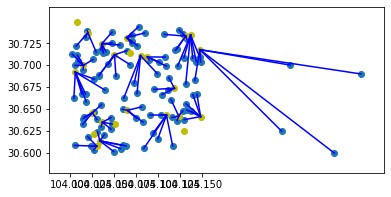

In [5]:
def optimize(table):
    table.sort(key=lambda e:e[1]["id"])
    for XXX in range(2):
        for idx in range(len(table)):
            point_a, point_a_driver = table[idx]
            # print(sum([caculate.geodesic(i[0],i[1]) for i in table]))
            # raw
            raw_distance_to_driver = caculate.geodesic(point_a, point_a_driver)
            raw_distance = [raw_distance_to_driver+caculate.geodesic(i[0],i[1]) for i in table]

            raw_mean_square_difference = []
            for line in table:
                users = [i[0] for i in table if i[1]==line[1]]
                raw_mean_square_difference.append(caculate.mean_square_difference(users))
            # print(">>> ", sum(raw_mean_square_difference))
            raw_mean_square_difference = list(np.array(raw_mean_square_difference) + caculate.mean_square_difference([i[0] for i in table if i[1]==point_a_driver]))
            # now
            all_distance_to_drivers = [caculate.geodesic(point_a,i[1]) for i in table]
            all_distance_to_point_a_driver = [caculate.geodesic(i[0],point_a_driver) for i in table]
            now_distance = zip(all_distance_to_drivers,all_distance_to_point_a_driver)
            now_distance = [sum(i) for i in now_distance]
            now_mean_square_difference = []
            for e,line in enumerate(table):
                table_a = table[:idx]+[[line[0], point_a_driver]]+table[idx+1:]
                table_a = table_a[:e]+[[point_a, line[1]]]+table_a[e+1:]
                users_a = [i[0] for i in table_a if i[1]==point_a_driver]
                users_b = [i[0] for i in table_a if i[1]==line[1]]
                now_mean_square_difference.append(caculate.mean_square_difference(users_a)+caculate.mean_square_difference(users_b))
            # difference
            distance_difference = np.array(raw_distance)-np.array(now_distance)
            std_difference = np.array(raw_mean_square_difference)-np.array(now_mean_square_difference)
            difference = list(distance_difference+std_difference*40)
            # print(max(difference))
            
            if (max(difference)>0.001):
                index_of_line_b = difference.index(max(difference))
                line_b = table[index_of_line_b]
                # exchange
                table[index_of_line_b] = [point_a, line_b[1]]
                table[idx] = [line_b[0], point_a_driver]
                if(debug==True):
                    coordinates = [i["coordinate"] for i in pdw.users_backup]
                    x,y = zip(*coordinates)
                    plt.scatter(x,y)
                    coordinates = [i["coordinate"] for i in pdw.drivers_backup]
                    x,y = zip(*coordinates)
                    plt.scatter(x,y,c = 'y')
                    for user,driver in table:
                        x,y = zip(user["coordinate"],driver["coordinate"])
                        plt.plot(x,y,color='b')
                    plt.xticks(np.arange(104.000,104.150,0.025))
                    plt.yticks(np.arange(30.600,30.750,0.025))
                    plt.gca().set_aspect(1)
                    plt.show()
    return table
table = optimize(table)

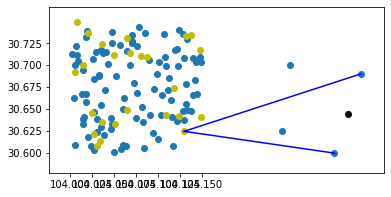

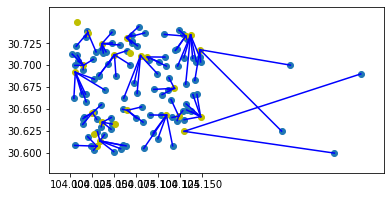

In [6]:
def handel_too_far(pdw, table):
    [pdw.users.append(i[0]) for i in table if caculate.geodesic(i[0],i[1])>max_distance]
    table = [i for i in table if caculate.geodesic(i[0],i[1])<max_distance]
    too_far=kmeans_distribute(pdw)
    table = table+too_far
    if(debug==True):
        coordinates = [i["coordinate"] for i in pdw.users_backup]
        x,y = zip(*coordinates)
        plt.scatter(x,y)
        coordinates = [i["coordinate"] for i in pdw.drivers_backup]
        x,y = zip(*coordinates)
        plt.scatter(x,y,c = 'y')
        for user,driver in table:
            x,y = zip(user["coordinate"],driver["coordinate"])
            plt.plot(x,y,color='b')
        plt.xticks(np.arange(104.000,104.150,0.025))
        plt.yticks(np.arange(30.600,30.750,0.025))
        plt.gca().set_aspect(1)
        plt.show()
    return table
table = handel_too_far(pdw, table)

In [ ]:
# def run():
#     table = kmeans_distribute(pdw)
#     table = optimize(table)
#     table = handel_too_far(pdw, table)